# **Springboard Decision Tree Specialty Coffee Case Study




In this exercise we will use the Random Forest, Entropy and Gini models to predict the potential number of coffee products/units would the loyal customers for RR Diner Coffee will purchase if RR Diner were to purchase their coffee from Hidden Farms Coffee in China. 



**1. Sourcing and loading** 

**2. Cleaning, transforming and visualizing**  
  
**3. Entropy and Gini Modelling** 

**4. Evaluating and concluding** 

**5. Random Forest Modelling** 
 

# 1. Sourcing and loading
## 1a. Import Packages

In [1]:
#Import Libs and Install pydotplus and IPython
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO  
from IPython.display import Image  
import pydotplus

## 1b. Load data 

In [2]:
# Read in the data to a variable called coffeeData
coffee_d = pd.read_csv('data/RRDinerCoffeeData.csv')

## 1c. Explore the data

In [3]:
# Call head() on your data 
coffee_d.head()

,Age,Gender,num_coffeeBags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
0,36,Female,0,24,73,42789,0.003168,0,1.0
1,24,Male,0,44,164,74035,0.520906,0,NaN
2,24,Male,0,39,119,30563,0.916005,1,1.0
3,20,Male,0,30,107,13166,0.932098,1,NaN
4,24,Female,0,20,36,14244,0.965881,0,1.0


In [4]:
# Call .shape on your data
coffee_d.shape

(702, 9)

In [76]:
# Call info() on your data
coffee_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      702 non-null    int64  
 1   Gender                   702 non-null    object 
 2   num_coffeeBags_per_year  702 non-null    int64  
 3   spent_week               702 non-null    int64  
 4   spent_month              702 non-null    int64  
 5   SlrAY                    702 non-null    int64  
 6   Distance                 702 non-null    float64
 7   Online                   702 non-null    int64  
 8   Decision                 474 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 49.5+ KB


In [5]:
# Summarize stats
coffee_d.describe()

,Age,num_coffeeBags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,474.000000
mean,34.243590,2.710826,32.853276,107.923077,43819.843305,4.559186,0.531339,0.639241
std,13.927945,1.593629,15.731878,55.348485,26192.626943,3.116275,0.499373,0.480728
min,16.000000,0.000000,0.000000,0.000000,1617.000000,0.003168,0.000000,0.000000
25%,23.000000,1.000000,24.250000,62.000000,22812.250000,1.877812,0.000000,0.000000
50%,28.000000,3.000000,36.000000,113.500000,41975.000000,4.196167,1.000000,1.000000
75%,46.000000,4.000000,43.000000,150.750000,60223.000000,6.712022,1.000000,1.000000
max,90.000000,5.000000,62.000000,210.000000,182058.000000,10.986203,1.000000,1.000000


# 2. Cleaning, transforming and visualizing
## 2a. Cleaning the data

In [6]:
# Print column names
print(coffee_d.columns)


Index(['Age', 'Gender', 'num_coffeeBags_per_year', 'spent_week', 'spent_month',
       'SlrAY', 'Distance', 'Online', 'Decision'],
      dtype='object')


In [7]:
# Column name changes & validate
coffee_d.rename(columns = {'spent_week':'spent_last_week',"spent_month":"spent_last_month","SlrAY":"Salary" }\
                  ,inplace=True)
print(coffee_d.columns)

Index(['Age', 'Gender', 'num_coffeeBags_per_year', 'spent_last_week',
       'spent_last_month', 'Salary', 'Distance', 'Online', 'Decision'],
      dtype='object')


In [8]:
# Validate Gender column values 
print (coffee_d['Gender'])


0      Female
1        Male
2        Male
3        Male
4      Female
        ...  
697    Female
698      Male
699      Male
700    Female
701      Male
Name: Gender, Length: 702, dtype: object


In [9]:
#Check unique values for Gender
coffee_d['Gender'].unique()


array(['Female', 'Male', 'female', 'F', 'f ', 'FEMALE', 'MALE', 'male',
       'M'], dtype=object)

We can see a bunch of inconsistency here.

Use replace() to make the values of the `gender` column just `Female` and `Male`.

In [10]:
# Standardize gender values for'Female' and validate
coffee_d['Gender'].replace(to_replace=['female','F','f ','FEMALE'], value='Female', inplace=True)
coffee_d['Gender'].unique()



array(['Female', 'Male', 'MALE', 'male', 'M'], dtype=object)

In [11]:
# Standardize gender values for'Male' and validate
coffee_d['Gender'].replace(to_replace=['male','M','MALE'], value='Male', inplace=True)
coffee_d['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
# Check out the unique values of the column 'Decision'
coffee_d['Decision'].unique()


array([ 1., nan,  0.])

We now want to replace `1.0` and `0.0` in the `Decision` column by `YES` and `NO` respectively.

In [13]:
# Creating category data for decisions: 0 = No, 1 = Yes and validate 
coffee_d['Decision'].replace(to_replace=1, value='YES', inplace=True)
coffee_d['Decision'].replace(to_replace=0, value='NO', inplace=True)
coffee_d['Decision'].unique()


array(['YES', nan, 'NO'], dtype=object)

## 2b. Splitting Data Into Train Test 

### 1. Drop all null values within the `Decision` 

In [14]:
# Drop null values and store in a new variable 
NoPrediction = coffee_d.dropna() 
NoPrediction.describe()

,Age,num_coffeeBags_per_year,spent_last_week,spent_last_month,Salary,Distance,Online
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,35.417722,2.590717,32.592827,106.727848,44731.892405,5.102898,0.512658
std,13.604135,1.585211,15.758109,56.101085,25567.674430,3.354891,0.500368
min,16.000000,0.000000,0.000000,0.000000,3150.000000,0.003168,0.000000
25%,25.000000,1.000000,24.000000,60.000000,27284.250000,2.077965,0.000000
50%,29.000000,3.000000,35.000000,113.500000,42791.500000,4.832168,1.000000
75%,49.000000,4.000000,43.000000,150.000000,61621.750000,7.869086,1.000000
max,90.000000,5.000000,62.000000,210.000000,172658.000000,10.986203,1.000000


### 2. Data Viz.

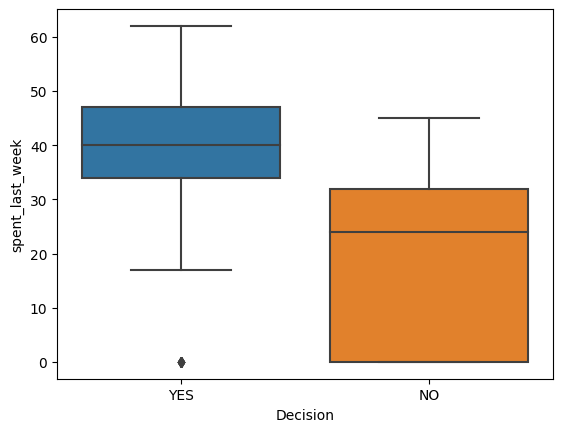

In [16]:
# Creating a boxplot
sns.boxplot(y="spent_last_week", x= "Decision", data=NoPrediction)
plt.show()

Existing customers spend more money


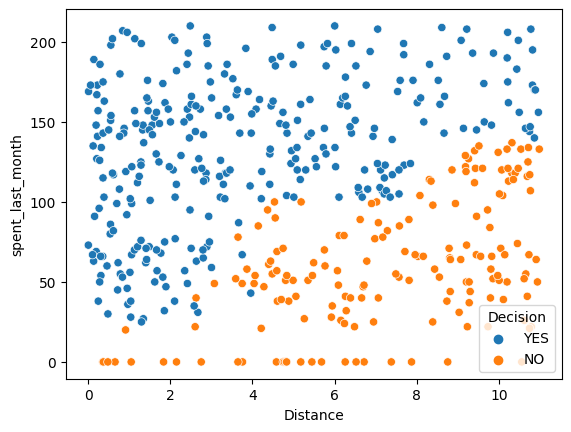

In [17]:
# Make a scatterplot on NOPrediction, where x is distance, y is spent_last_month and hue is Decision 
sns.scatterplot(y="spent_last_month", x= "Distance", hue = "Decision", data =NoPrediction)
plt.show()

There is a clear diagonal decision boundary for customers who purchase the product and those who do not. There is a higher concentration of spenders in less distance indicating some correlation 

### 3. Get the subset of coffeeData with null values in the Decision column, and save that subset as Prediction

In [19]:
# Get Decision column null values
Prediction = coffee_d[pd.isnull(coffee_d['Decision'])]
Prediction.head()
Prediction.describe()


,Age,num_coffeeBags_per_year,spent_last_week,spent_last_month,Salary,Distance,Online
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,31.802632,2.960526,33.394737,110.407895,41923.741228,3.428836,0.570175
std,14.302293,1.585514,15.697930,53.786536,27406.768360,2.153102,0.496140
min,16.000000,0.000000,0.000000,0.000000,1617.000000,0.010048,0.000000
25%,22.000000,2.000000,25.750000,65.000000,15911.500000,1.699408,0.000000
50%,25.000000,3.000000,37.000000,113.500000,40987.500000,3.208673,1.000000
75%,39.000000,4.000000,44.000000,151.250000,58537.000000,5.261184,1.000000
max,67.000000,5.000000,62.000000,210.000000,182058.000000,10.871566,1.000000


### 4. Divide the NOPrediction subset into X and y

In [20]:
# Check the names of the columns of NOPrediction
print(NoPrediction.columns)

Index(['Age', 'Gender', 'num_coffeeBags_per_year', 'spent_last_week',
       'spent_last_month', 'Salary', 'Distance', 'Online', 'Decision'],
      dtype='object')


In [21]:
# Feature selection including explanatory and dependent variable creation
features = ["Age", "Gender", "num_coffeeBags_per_year", "spent_last_week", "spent_last_month",
       "Salary", "Distance", "Online"]

X = NoPrediction[features]

y = NoPrediction.Decision

### 5. Creating dummy variables for categorical inputs

In [22]:
# Hot encoding features in X.
X = pd.get_dummies(X)


### 6. Further division of data subsets into train and test subsets for X and y 

In [23]:
# Call train_test_split on X, y. Make the test_size = 0.25, and random_state = 246
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.25, random_state = 246)


# 3. Modelling

## Model 1: Entropy model - no max_depth

In [24]:
# Model setup steps 
entr_model = tree.DecisionTreeClassifier(criterion="entropy", random_state = 1234)

entr_model.fit(X_train, y_train)

y_pred = entr_model.predict(X_test)

y_pred = pd.Series(y_pred)


entr_model

DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [101]:
# Data viz for Decision Tree using graphviz
#Installing graphviz on Mac using brew for this step however it continues to generate the same error: "InvocationException: GraphViz's executables not found"

dot_data = StringIO()
tree.export_graphviz(entr_model, out_file=dot_data,  filled=True,\
                     rounded=True, special_characters=True,\
                     feature_names=X_train.columns,class_names = ["NO", "YES"]) 

# For class_names Data Viz use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

## Model 1: Entropy  no max_depth: Interpretation and evaluation

In [100]:
# Run this block for model evaluation metrics 
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = "NO"))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = "YES"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Entropy - no max depth
Accuracy: 0.9915966386554622
Balanced accuracy: 0.9878048780487805
Precision score for "Yes" 0.9873417721518988
Precision score for "No" 1.0
Recall score for "Yes" 1.0
Recall score for "No" 0.975609756097561


The model has an accuracy of 0.99, indicating that it correctly predicted 99% of the data. The balanced accuracy score is also high at 98.7%, suggesting that the model is not affected by class imbalance. The precision score for 'Yes' is also impressive at 98.7%, but there may be false positive predictions for 'Yes'. On the other hand, the precision score for 'No' is perfect at 1, indicating no false negative predictions for 'No'. The recall score for 'Yes' is 1, indicating that all 'Yes' predictions were correct. However, the recall score for 'No' is 97.5%, which is reasonable considering the presence of false positive predictions for 'Yes'. The model performs almost flawlessly in predicting the class of each data point. It is highly likely that the model is overfitting and has high variance, but it could also be due to the simplicity of the features and the predictability of the data classes.

## Model 2: Gini impurity model - no max_depth

In [26]:
# Create a Gini impurity based model using similar approach
gini_model = tree.DecisionTreeClassifier(criterion="gini", random_state = 1234)

gini_model.fit(X_train,y_train)

y_pred = gini_model.predict(X_test)

y_pred = pd.Series(y_pred)

gini_model

DecisionTreeClassifier(random_state=1234)

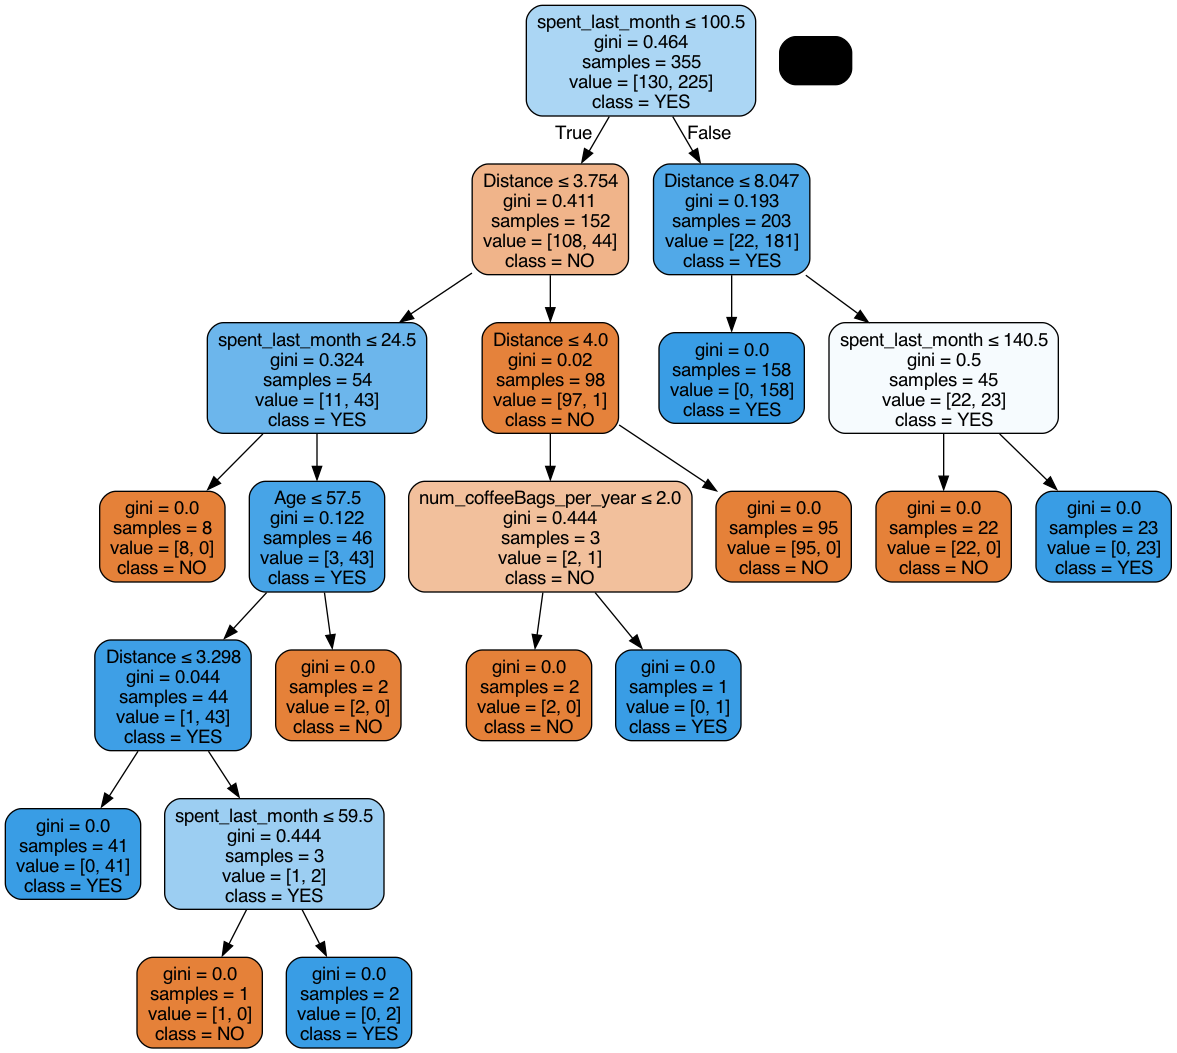

In [27]:
# Visualize gini_model and for class_names use gini_model.classes_
dot_data = StringIO()
tree.export_graphviz (gini_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"])

graph_g = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph_g.create_png())

In [28]:
# Perform Model evaluation
print("Model Gini impurity model")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Gini impurity model
Accuracy: 0.9831932773109243
Balanced accuracy: 0.9813946216385241
Precision score 0.9871794871794872
Recall score 0.975609756097561


ANALYSIS:
There is a slight performance reduction in the Model 2 (Gini - no depth) as compared to Entropy (no-depth)

## Model 3: Entropy model - max depth 3

In [30]:
# Create a second Entropy model with max_depth parameter of 3 and apply fitting, predicting, and Series 
entr_model2 = tree.DecisionTreeClassifier(criterion="entropy", random_state = 1234, max_depth = 3)

entr_model2.fit(X_train, y_train)

y_pred = entr_model2.predict(X_test)

y_pred = pd.Series(y_pred)

entr_model2

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1234)

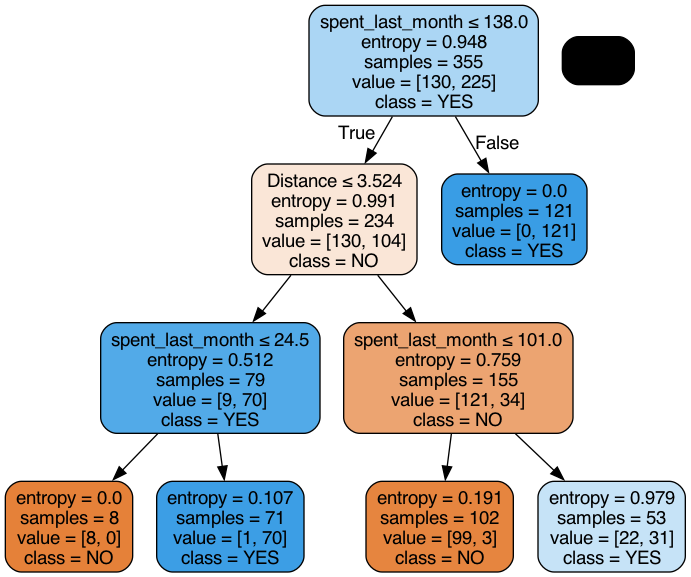

In [31]:
# Visualize the second Entropy Model with depth of 3
dot_data = StringIO()


tree.export_graphviz(entr_model2, out_file=dot_data,  filled=True,\
                     rounded=True, special_characters=True,\
                     feature_names=X_train.columns,class_names = ["NO", "YES"]) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [32]:
# Perform model evaluation 
print("Model Entropy model max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Entropy model max depth 3
Accuracy: 0.907563025210084
Balanced accuracy: 0.8658536585365854
Precision score for "Yes" 0.8764044943820225
Recall score for "No" 0.7317073170731707


ANALYSIS: 
The model accuracy decreased, however, it's possible that this model is higher adapatibility

## Model 4: Gini impurity  model - max depth 3

In [33]:
# Create a second Gini model with max_depth parameter of 3 and apply fitting, predicting, and Series 
gini_model2 = tree.DecisionTreeClassifier(criterion="gini", random_state = 1234, max_depth=3)

gini_model2.fit(X_train,y_train)

y_pred = gini_model2.predict(X_test)

y_pred = pd.Series(y_pred)

gini_model2

DecisionTreeClassifier(max_depth=3, random_state=1234)

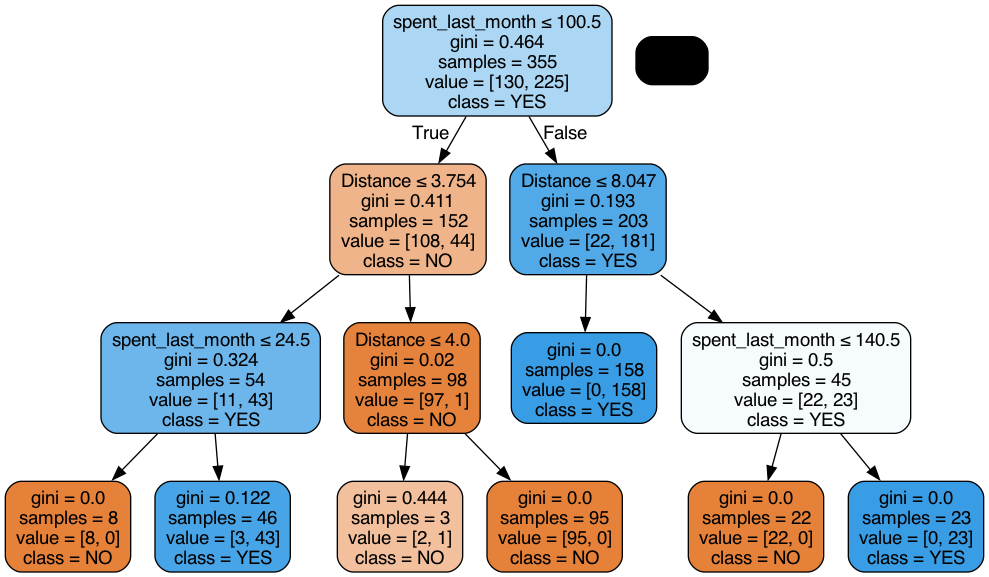

In [34]:
# Visualize the second gini Model with depth of 3

dot_data = StringIO()
tree.export_graphviz (gini_model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [35]:
print("Gini impurity  model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Gini impurity  model - max depth 3
Accuracy: 0.9747899159663865
Balanced accuracy: 0.9691994996873046
Precision score 0.9746835443037974
Recall score 0.9512195121951219


ANALYSIS:
The Gini max depth=3 model is not only a high performant model but also has shallow depth makes. This may indicate that this model more generalizable and less prone to overfitting while still maintaining high performance.

# 4. Evaluating and concluding
## 4a. How many customers will buy Hidden Farm coffee? 
Let's first ascertain how many loyal customers claimed, in the survey, that they will purchase the Hidden Farm coffee. 

In [36]:
# Determine count of loyals by using counts() on the 'Decision' column of the original coffee data 
coffee_d.Decision.value_counts()


YES    303
NO     171
Name: Decision, dtype: int64

Let's now determine the number of people that, according to the model, will be willing to buy the Hidden Farm coffee. 
1. First we subset the Prediction dataset into `new_X` considering all the variables except `Decision` 
2. Use that dataset to predict a new variable called `potential_buyers`

In [38]:
# Feature selection
feature_cols = ["Age", "Gender", "num_coffeeBags_per_year", "spent_last_week", "spent_last_month",
       "Salary", "Distance", "Online"]

# Make a variable called new_X, and assign it the subset of Prediction, containing just the feature_cols 
new_X = Prediction[feature_cols]

In [39]:
# One-hot encode all features in the training set by calling get_dummies() with new_X plugged in
new_X = pd.get_dummies(new_X)

# Make a variable called potential_buyers, and assign it the result of calling predict() by calling the second entropy model 
potential_buyers = entr_model2.predict(new_X)

In [40]:
# Let's get the numbers of YES's and NO's in the potential buyers 
# Call unique() on np, and pass potential_buyers and return_counts=True 
np.unique(potential_buyers, return_counts= True)


(array(['NO', 'YES'], dtype=object), array([ 45, 183]))

The total number of potential buyers is 303 + 183 = 486

In [43]:
# Print the total number of surveyed people 
print("The total number of surveyed people was", coffee_d.Salary.count())

The total number of surveyed people was 702


In [41]:
# Let's calculate the proportion of buyers
486/702

0.6923076923076923

In [44]:
# Print the percentage of people who want to buy the Hidden Farm coffee, by our model 
print("Only ", round((486/702)*100, 2), "% of people want to buy the Hidden Farm coffee." )


Only  69.23 % of people want to buy the Hidden Farm coffee.


## 4. Random Forest Modelling

### 5a. Import libraries

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### 5b. Building the RF Model

In [46]:
# Plug in appropriate max_depth and random_state parameters 
RFModel = RandomForestClassifier(max_depth= 3, random_state= 1234)

# Model and fit
RFModel.fit(X_train, y_train)

# Predict on X_test:
y_pred = RFModel.predict(X_test)

# Turning y_pred into a pandas series:
y_pred = pd.Series(y_pred)


### 5c. Review conclusion Compared To Previous Models (Gini & Entropy)

In [53]:
# Print Model Summary
print("Random Forest  model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Random Forest  model - max depth 3
Accuracy: 0.9411764705882353
Balanced accuracy: 0.9204190118824265
Precision score 0.927710843373494
Recall score 0.8536585365853658


ANALYSIS:
The RF Model is more generalized model than the gini model with max depth 3. 
We will now evaluate the RF Model predictions.


In [54]:
# Call value_counts() on the 'Decision' column of the original coffeeData
coffee_d.Decision.value_counts()

YES    303
NO     171
Name: Decision, dtype: int64

In [55]:
# Assigning predictions of the RF model to  a new potential_buyers var:
potential_buyers_2 = RFModel.predict(new_X)


In [56]:
# Let's get the numbers of YES's and NO's in the potential buyers 
# Call unique() on np, and pass potential_buyers and return_counts=True 
np.unique(potential_buyers_2, return_counts= True)

(array(['NO', 'YES'], dtype=object), array([ 39, 189]))

In [57]:
# Calculating the proportion of buyers
492/702

0.7008547008547008

In [58]:
# Using the RF Model the percentage of people who want to buy the Hidden Farm coffee is 
print("Only ", round((486/702)*100, 2), "% of people want to buy the Hidden Farm coffee." )

Only  69.23 % of people want to buy the Hidden Farm coffee.
